In [9]:
import pandas as pd
from pathlib import Path
import json
import seaborn as sns
import requests
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [10]:
WEATHER_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "combined_data", "combined_weather.parquet"
)
WEATHER_MAPPING = Path(
    Path.cwd().parent, "data_information", "weather_location_mapping.json"
)

In [11]:
weather_df = pd.read_parquet(WEATHER_LOAD_DIR)

In [12]:
weather_df = weather_df.drop(
    list(weather_df.keys())[-1], axis=1
)  # weird empty column at the end of df

In [13]:
weather_df.head()

,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
0,2011-03-02,2011-02-27,Actual,ALB,37,22,32,21.0
1,2011-03-02,2011-02-27,Actual,ART,39,19,35,18.0
2,2011-03-02,2011-02-27,Actual,BGM,34,26,31,25.0
3,2011-03-02,2011-02-27,Actual,BUF,38,26,35,26.0
4,2011-03-02,2011-02-27,Actual,ELM,39,27,35,26.0


# Mapping Station ID to location

In order to map the correct weather station to the energy demand data, we need to map it to a location.
I've manually looked up where each of the stations are and mapped them in data information/weather_location_map.json

In [14]:
[x for x in weather_df["Station ID"].unique()]

['ALB',
 'ART',
 'BGM',
 'BUF',
 'ELM',
 'HPN',
 'ISP',
 'JFK',
 'LGA',
 'MSS',
 'MSV',
 'PLB',
 'POU',
 'ROC',
 'SWF',
 'SYR',
 'UCA',
 'ELZ',
 'FOK',
 'FRG',
 'GFL',
 'IAG',
 'ITH',
 'NYC',
 'SLK']

In [15]:
weather_mapping = json.loads(Path(WEATHER_MAPPING).read_text(encoding="UTF-8"))['lat_lon']
weather_mapping

{'ALB': ['42.652580', '-73.756233'],
 'ART': ['43.974785', '-75.910759'],
 'BGM': ['42.098843', '-75.920647'],
 'BUF': ['42.880230', '-78.878738'],
 'ELM': ['42.084972', '-76.798553'],
 'HPN': ['41.033985', '-73.762909'],
 'ISP': ['40.732071', '-73.186180'],
 'LGA': ['40.7769', '-73.8740'],
 'JFK': ['40.641766', '-73.780968'],
 'MSS': ['44.933910', '-74.897629'],
 'MSV': ['41.6556', '-74.6893'],
 'PLB': ['44.699764', '-73.471428'],
 'POU': ['41.708290', '-73.923912'],
 'ROC': ['43.161030', '-77.610924'],
 'SWF': ['41.512177', '-74.018326'],
 'SYR': ['43.088947', '-76.154480'],
 'UCA': ['43.227978', '-75.484924']}

Note we have some cities in our dataframe which we dont have location info for. This is due to the information on translating the area codes to actual places isn't complete. 
We'll drop any cities we dont have location data for. 

In [16]:
cities_with_location_data = set(weather_mapping.keys())
cities_in_weather_df = set(weather_df["Station ID"].unique())
cities_intersection = list(cities_in_weather_df.intersection(cities_with_location_data))

In [17]:
print(
    f"""{weather_df.shape[0] - 
      weather_df[weather_df['Station ID'].isin(cities_intersection)].shape[0]} rows removed"""
)
weather_df = weather_df[weather_df["Station ID"].isin(cities_intersection)].reset_index(
    drop=True
)

82120 rows removed


In [18]:
weather_df["lat_lon"] = weather_df["Station ID"].map(weather_mapping)

In [19]:
# splitting the lat lon column into two seperate columns
lat_lon_df = pd.DataFrame(weather_df["lat_lon"].values.tolist()).rename(
    columns={0: "lat", 1: "lon"}
)
weather_df = pd.concat([weather_df, lat_lon_df], axis=1).drop(
    "lat_lon", axis=1, errors="ignore"
)
weather_df["lat"] = weather_df["lat"].astype(float)
weather_df["lon"] = weather_df["lon"].astype(float)
weather_df["Max Wet Bulb"] = weather_df["Max Wet Bulb"].astype(float)

In [20]:
weather_df.head()

,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,lat,lon
0,2011-03-02,2011-02-27,Actual,ALB,37,22,32.0,21.0,42.652580,-73.756233
1,2011-03-02,2011-02-27,Actual,ART,39,19,35.0,18.0,43.974785,-75.910759
2,2011-03-02,2011-02-27,Actual,BGM,34,26,31.0,25.0,42.098843,-75.920647
3,2011-03-02,2011-02-27,Actual,BUF,38,26,35.0,26.0,42.880230,-78.878738
4,2011-03-02,2011-02-27,Actual,ELM,39,27,35.0,26.0,42.084972,-76.798553


In [21]:
weather_df["Forecast Date"] = pd.to_datetime(weather_df["Forecast Date"])
weather_df["Vintage Date"] = pd.to_datetime(weather_df["Vintage Date"])

In [22]:
weather_df["Forecast Year"] = weather_df["Forecast Date"].dt.year
weather_df["Forecast Month"] = weather_df["Forecast Date"].dt.month
weather_df["Forecast Day"] = weather_df["Forecast Date"].dt.day

weather_df["Vintage Year"] = weather_df["Vintage Date"].dt.year
weather_df["Vintage Month"] = weather_df["Vintage Date"].dt.month
weather_df["Vintage Day"] = weather_df["Vintage Date"].dt.day

## Data Stats

In [23]:
weather_df.isna().sum()

Forecast Date         0
Vintage Date          0
Vintage               0
Station ID            0
Max Temp              0
Min Temp              0
Max Wet Bulb          0
Min Wet Bulb      23460
lat                   0
lon                   0
Forecast Year         0
Forecast Month        0
Forecast Day          0
Vintage Year          0
Vintage Month         0
Vintage Day           0
dtype: int64

In [24]:
weather_df.describe()

,Forecast Date,Vintage Date,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,lat,lon,Forecast Year,Forecast Month,Forecast Day,Vintage Year,Vintage Month,Vintage Day
count,455039,455039,455039.000000,455039.000000,455039.000000,431579.000000,455039.000000,455039.000000,455039.000000,455039.000000,455039.000000,455039.000000,455039.000000,455039.000000
mean,2016-02-11 07:18:07.652706816,2016-02-10 07:13:17.145739008,58.043541,41.563011,49.873237,38.711061,42.403755,-75.065877,2015.615497,6.497889,15.727575,2015.612807,6.497553,15.716517
min,2008-09-08 00:00:00,2008-09-05 00:00:00,-10.000000,-99.000000,-10.000000,-999.000000,40.641766,-78.878738,2008.000000,1.000000,1.000000,2008.000000,1.000000,1.000000
25%,2012-06-18 00:00:00,2012-06-17 00:00:00,42.000000,28.000000,37.000000,26.000000,41.512177,-75.920647,2012.000000,3.000000,8.000000,2012.000000,3.000000,8.000000
50%,2016-02-16 00:00:00,2016-02-15 00:00:00,59.000000,42.000000,51.000000,39.000000,42.098843,-74.689300,2016.000000,6.000000,16.000000,2016.000000,6.000000,16.000000
75%,2019-10-17 00:00:00,2019-10-16 00:00:00,75.000000,57.000000,64.000000,54.000000,43.161030,-73.780968,2019.000000,10.000000,23.000000,2019.000000,10.000000,23.000000
max,2023-06-16 00:00:00,2023-06-17 00:00:00,124.000000,86.000000,88.000000,77.000000,44.933910,-73.186180,2023.000000,12.000000,31.000000,2023.000000,12.000000,31.000000
std,NaN,NaN,19.595061,18.315048,16.432365,19.001833,1.297231,1.570951,4.269623,3.470719,8.785264,4.269563,3.470891,8.787601


We Might be able to impute the min wet bulb temeprature using the available min temperature

# Visualizing

Where are out stations located?

In [25]:
station_locations = (
    weather_df[["Station ID", "lat", "lon"]]
    .groupby("Station ID", as_index=False)
    .mean()
)

In [26]:
fig = go.Figure(
    data=go.Scattergeo(
        lon=station_locations["lon"],
        lat=station_locations["lat"],
        text=station_locations["Station ID"],
        mode="markers",
    )
)


# Adding state lines - from
# https://stackoverflow.com/questions/71230623/how-to-show-state-boundaries-only-for-us-on-a-world-scatter-geo
states_geojson = requests.get(
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_1_states_provinces_lines.geojson"
).json()


fig = fig.add_trace(
    go.Scattergeo(
        lat=[
            v
            for sub in [
                np.array(f["geometry"]["coordinates"])[:, 1].tolist() + [None]
                for f in states_geojson["features"]
            ]
            for v in sub
        ],
        lon=[
            v
            for sub in [
                np.array(f["geometry"]["coordinates"])[:, 0].tolist() + [None]
                for f in states_geojson["features"]
            ]
            for v in sub
        ],
        line_color="brown",
        line_width=1,
        mode="lines",
        showlegend=False,
    )
)
fig.update_layout(
    title="Weather Station Locations",
    geo=dict(scope="usa", projection_type="albers usa", showland=True),
)

lat_foc = 43.2
lon_foc = -75.5
fig.update_layout(
    geo=dict(
        projection_scale=5,  # this is kind of like zoom
        center=dict(lat=lat_foc, lon=lon_foc),  # this will center on the point
    )
)

fig.show()

They all appear to be within NY state boundaries which is reassuring!

## Monthly min and max temps by station

In [27]:
monthly_min_max_by_station = weather_df.groupby(
    ["Station ID", "Forecast Month"], as_index=False
).mean(numeric_only=True)[["Station ID", "Forecast Month", "Max Temp", "Min Temp"]]

In [28]:
monthly_min_max_by_station.head()

,Station ID,Forecast Month,Max Temp,Min Temp
0,ALB,1,32.164211,18.072357
1,ALB,2,35.062708,19.283610
2,ALB,3,44.311377,27.903764
3,ALB,4,57.910067,38.587025
4,ALB,5,70.261698,50.067158


There are too many stations to clearly plot, so we'll just pick three that represent the corners of the state - JFK Airport, Buffalo and Massena

Text(0.5, 1.0, 'Min/Max temperature by month')

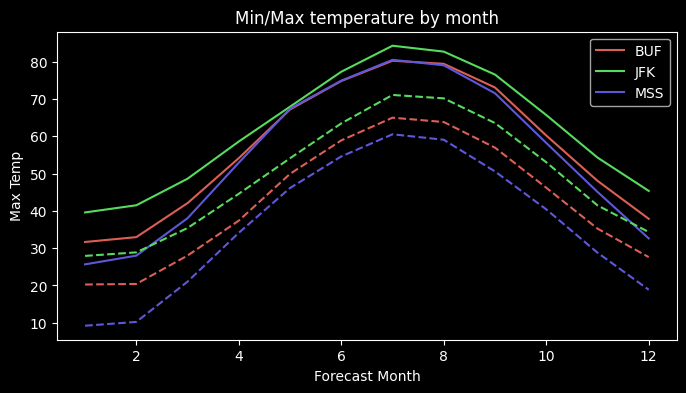

In [29]:
jfk_mss_buff_df = monthly_min_max_by_station[
    monthly_min_max_by_station["Station ID"].isin(["MSS", "JFK", "BUF"])
].reset_index(drop=True)
# Seaborn legend contains all categorical elements from full df, so need to remove these
jfk_mss_buff_df["Station ID"] = jfk_mss_buff_df[
    "Station ID"
].cat.remove_unused_categories()

fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=jfk_mss_buff_df,
    x="Forecast Month",
    y="Max Temp",
    hue="Station ID",
    ax=ax,
    palette=sns.color_palette("hls", 3),
)

sns.lineplot(
    data=jfk_mss_buff_df,
    x="Forecast Month",
    y="Min Temp",
    hue="Station ID",
    ax=ax,
    palette=sns.color_palette("hls", 3),
    linestyle="dashed",
)
# Removing repeated legend elements
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_title("Min/Max temperature by month")

In [30]:
weather_df.head()

,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,lat,lon,Forecast Year,Forecast Month,Forecast Day,Vintage Year,Vintage Month,Vintage Day
0,2011-03-02,2011-02-27,Actual,ALB,37,22,32.0,21.0,42.652580,-73.756233,2011,3,2,2011,2,27
1,2011-03-02,2011-02-27,Actual,ART,39,19,35.0,18.0,43.974785,-75.910759,2011,3,2,2011,2,27
2,2011-03-02,2011-02-27,Actual,BGM,34,26,31.0,25.0,42.098843,-75.920647,2011,3,2,2011,2,27
3,2011-03-02,2011-02-27,Actual,BUF,38,26,35.0,26.0,42.880230,-78.878738,2011,3,2,2011,2,27
4,2011-03-02,2011-02-27,Actual,ELM,39,27,35.0,26.0,42.084972,-76.798553,2011,3,2,2011,2,27


## Long Term Trends

We can investigate how max temperature has changed over time. 

In [31]:
long_term_max_temp = (
    weather_df.groupby(["Station ID", "Forecast Year"], as_index=False)
    .max(numeric_only=True)[["Station ID", "Forecast Year", "Max Temp"]]
    .dropna(subset="Max Temp")
)

In [32]:
long_term_max_temp = long_term_max_temp[
    long_term_max_temp["Station ID"].isin(["MSS", "JFK", "BUF"])
].reset_index(drop=True)
long_term_max_temp.head()
long_term_max_temp["Station ID"] = long_term_max_temp[
    "Station ID"
].cat.remove_unused_categories()
# Dropping any 2023 rows as it's not summer yet
long_term_max_temp = long_term_max_temp[long_term_max_temp["Forecast Year"] != 2023]

Text(0.5, 1.0, 'Max temperature by year')

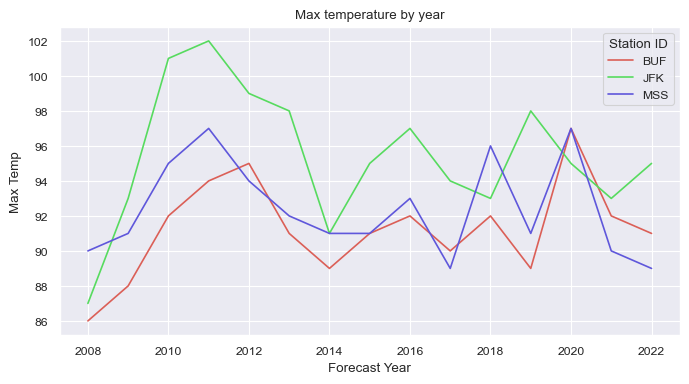

In [33]:
sns.set_theme("paper")
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(
    data=long_term_max_temp,
    x="Forecast Year",
    y="Max Temp",
    hue="Station ID",
    ax=ax,
    palette=sns.color_palette("hls", 3),
)

ax.set_title("Max temperature by year")

Doesnt really seem to be any sort of long term trend

## Correlations

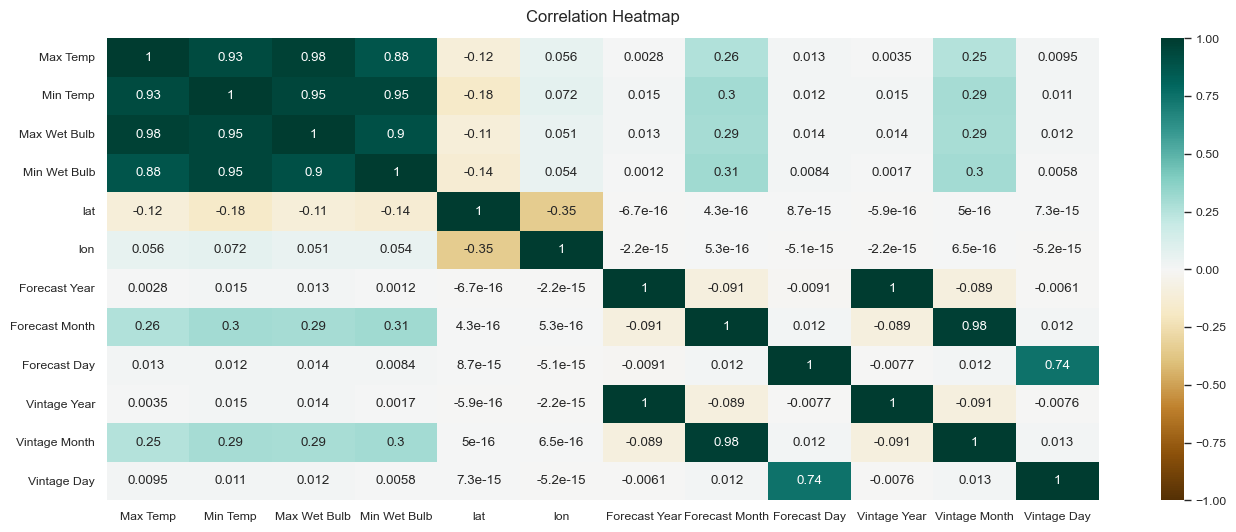

In [34]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(
    weather_df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap="BrBG"
)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12);

In [35]:
WEATHER_SAVE_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "weather_transformed.parquet"
)

In [36]:
weather_df.to_parquet(WEATHER_SAVE_DIR)